# State farm distracted driver detection

In [1]:
# 使用するモジュールのインポート
import os.path as osp
from glob import glob
import random
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
# Seed値の固定
SEED = 42
fix_seed(SEED)

# 各クラスの説明の定義
activity_map = {
    'c0': 'Safe driving', 
    'c1': 'Texting - right', 
    'c2': 'Talking on the phone - right', 
    'c3': 'Texting - left', 
    'c4': 'Talking on the phone - left', 
    'c5': 'Operating the radio', 
    'c6': 'Drinking', 
    'c7': 'Reaching behind', 
    'c8': 'Hair and makeup', 
    'c9': 'Talking to passenger'
}

# パスの定義
data_dir = '../input/state-farm-distracted-driver-detection'
csv_file_path = osp.join(data_dir, 'driver_imgs_list.csv')

In [4]:
df = pd.read_csv(csv_file_path) # csvファイルの読み込み
df.head(5) # 最初の5行を表示

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


# EDA

In [5]:
by_drivers = df.groupby('subject') # ドライバーでグループ化
unique_drivers = by_drivers.groups.keys() # ドライバー名のリスト

# データセットに含まれるドライバーの数
print('unique drivers: ',len(unique_drivers)) 
# ドライバー1人当たりの画像の数の平均
print('mean of images: ', round(df.groupby('subject').count()['classname'].mean()))

unique drivers:  26
mean of images:  862


In [6]:
train_file_num = len(glob(osp.join(data_dir, 'imgs/train/*/*.jpg'))) # 訓練データの数
test_file_num = len(glob(osp.join(data_dir, 'imgs/test/*.jpg'))) # テストデータの数
category_num = len(df['classname'].unique()) # カテゴリの数
print('train_file_num: ', train_file_num)
print('test_file_num: ', test_file_num)
print('category_num: ', category_num)

train_file_num:  22424
test_file_num:  79726
category_num:  10


In [7]:
# クラスごとのデータ数
px.histogram(df, x="classname", color="classname", title="Number of images by categories ")

In [8]:
drivers_id = pd.DataFrame((df['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
px.histogram(drivers_id, x="driver_id",y="Counts" ,color="driver_id", title="Number of images by subjects ")

In [9]:
# ドライバーごとの画像の数のヒストグラム
# 自分で実装
px.histogram(df, x='subject', color='subject', title='Number of images by subjects')

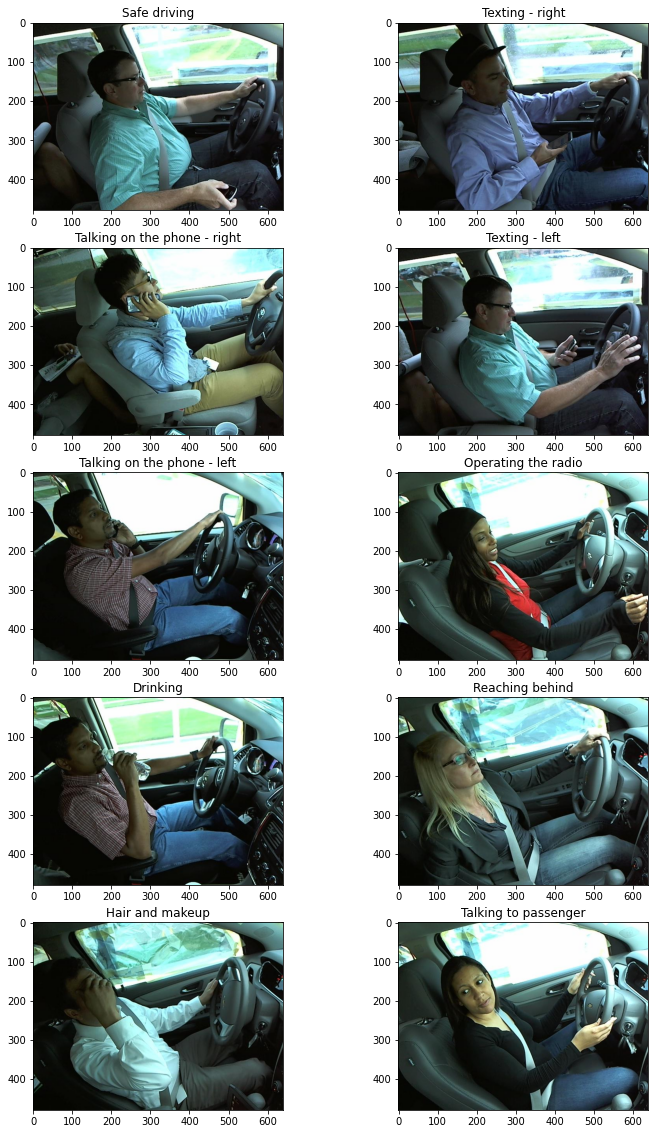

In [10]:
# 各クラスのデータを描画
# 自分で実装
plt.figure(figsize=(12, 20))
for i, (key, value) in enumerate(activity_map.items()):
    image_dir = osp.join(data_dir, 'imgs/train', key, '*.jpg')
    image_path = glob(image_dir)[0]
    image = cv2.imread(image_path)[:, :, (2, 1, 0)]
    plt.subplot(5, 2, i+1)
    plt.imshow(image)
    plt.title(value)

# 前処理

In [11]:
# ファイルパスの列を追加
# 自分で実装
df['file_path'] = df.apply(lambda x: osp.join(data_dir, 'imgs/train', x.classname, x.img), axis=1)

# 正解ラベルを数値に変換して列を追加
# 自分で実装
df['class_num'] = df['classname'].map(lambda x: int(x[1]))
df.head(5)

,subject,classname,img,file_path,class_num
0,p002,c0,img_44733.jpg,../input/state-farm-distracted-driver-detectio...,0
1,p002,c0,img_72999.jpg,../input/state-farm-distracted-driver-detectio...,0
2,p002,c0,img_25094.jpg,../input/state-farm-distracted-driver-detectio...,0
3,p002,c0,img_69092.jpg,../input/state-farm-distracted-driver-detectio...,0
4,p002,c0,img_92629.jpg,../input/state-farm-distracted-driver-detectio...,0


# Datasetの作成

In [12]:
class DataTransform():
    """
    画像とアノテーションの前処理クラス。訓練時と検証時で異なる動作をする。
    画像のサイズをinput_size x input_sizeにする。
    訓練時はデータオーギュメンテーションする。


    Attributes
    ----------
    input_size : int
        リサイズ先の画像の大きさ。
    color_mean : (R, G, B)
        各色チャネルの平均値。
    color_std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            # trainだけ自分で実装
            'train': A.Compose([
                A.HorizontalFlip(p=0.5),
                A.Rotate(-10, 10),
                A.Resize(input_size, input_size),  # リサイズ(input_size)
                A.Normalize(color_mean, color_std),  # 色情報の標準化
                ToTensorV2() # テンソル化
            ]),
            'val': A.Compose([
                A.Resize(input_size, input_size),  # リサイズ(input_size)
                A.Normalize(color_mean, color_std),  # 色情報の標準化
                ToTensorV2() # テンソル化
            ])
        }

    def __call__(self, phase, image):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        transformed = self.data_transform[phase](image=image)
        return transformed['image']

In [13]:
class Dataset(data.Dataset):
    """
    Attributes
    ----------
    df : DataFrame
        class_num, file_pathのカラムがあるデータフレーム
    phase : 'train' or 'val'
        学習か訓練かを設定する。
    transform : object
        前処理クラスのインスタンス
    """
    def __init__(self, df, phase, transform):
        self.df = df
        self.phase = phase
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.df)

    def __getitem__(self, index):
        '''前処理をした画像のTensor形式のデータを取得'''
        image = self.pull_item(index)
        return image, self.df.iloc[index]['class_num']

    def pull_item(self, index):
        '''画像のTensor形式のデータを取得する'''
        
        # 自分で実装
        # 1. 画像読み込み
        image_path = self.df.iloc[index]['file_path']
        image = cv2.imread(image_path)[:, :, (2, 1, 0)]

        # 2. 前処理を実施
        return self.transform(self.phase, image)

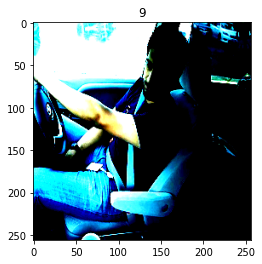

In [14]:
# 動作確認

# (RGB)の色の平均値と標準偏差
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
input_size = 256

# データ分割
df_train, df_val = train_test_split(df, stratify=df['subject'], random_state=SEED)

# 自分で実装
# データセット作成
train_dataset = Dataset(df_train, phase="train", transform=DataTransform(
    input_size=input_size, color_mean=color_mean, color_std=color_std))

val_dataset = Dataset(df_val, phase="val", transform=DataTransform(
    input_size=input_size, color_mean=color_mean, color_std=color_std))

# 自分で実装
# データの取り出し例
image, label = train_dataset[0]
plt.imshow(image.permute(1, 2, 0))
plt.title(label)
plt.show()

# DataLoaderの作成

In [15]:
# データローダーの作成
batch_size = 64

# 自分で実装
train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 自分で実装
# 動作の確認
batch_iterator = iter(dataloaders_dict["val"])  # イタレータに変換
images, labels = next(batch_iterator)  # 1番目の要素を取り出す
print(images.size())  # torch.Size([8, 3, 256, 256])
print(labels.size())  # torch.Size([8])

torch.Size([64, 3, 256, 256])
torch.Size([64])


# モデルの作成

In [16]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10)

# 自分で実装(練習)
# class Model(nn.Module):
#     def __init__(self, num_classes=10):
#         super(Model, self).__init__()
#         self.net = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(num_features=64),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(num_features=16),
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(in_features=65536, out_features=num_classes)
#         )
    
#     def forward(self, x):
#         output = self.net(x)
#         return output
# 
# model = Model(num_classes=10)

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=f3bc47e1b33f624966a47144997ffc23b24581fcf1d972cd0571c742d484a4c5
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


# 学習

In [17]:
# 自分で実装(練習)
# train_dataset = Dataset(df_train.iloc[:1000], phase="train", transform=DataTransform(
#     input_size=input_size, color_mean=color_mean, color_std=color_std))

# val_dataset = Dataset(df_val.iloc[:1000], phase="val", transform=DataTransform(
#     input_size=input_size, color_mean=color_mean, color_std=color_std))

# train_dataloader = data.DataLoader(
#     train_dataset, batch_size=batch_size, shuffle=True)

# val_dataloader = data.DataLoader(
#     val_dataset, batch_size=batch_size, shuffle=False)

# # 辞書オブジェクトにまとめる
# dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.CrossEntropyLoss()

# model = model.to(device)
# for epoch in range(5):
#     print(f'epoch: {epoch+1}')
#     print('-'*50)
    
#     # train
#     model.train()
#     train_loss = 0
#     for images, labels in train_dataloader:
#         images = images.to(device)
#         labels = labels.to(device)
        
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
        
#         loss.backward()
#         optimizer.step()
        
#         train_loss += loss.item() / len(images)
        
#     print(f'epoch train loss: {train_loss: .4f}')

#     # valid
#     model.eval()
#     valid_loss = 0
#     preds = []
#     trues = []
#     for images, labels in val_dataloader:
#         images = images.to(device)
#         labels = labels.to(device)
        
#         with torch.no_grad():
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             valid_loss = loss.item() / len(images)
            
#             trues += list(labels.cpu().numpy())
#             preds += list(outputs.argmax(axis=1).cpu().numpy())
    
#     accuracy = accuracy_score(trues, preds)
#     print(f'epoch valid loss: {valid_loss: .4f} accuracy: {accuracy: .4f}\n')

In [18]:
# チェックポイントの保存
def save_checkpoint(model, optimizer, scheduler, epoch, path):
    torch.save(
        {'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(), 
        }, path)

# チェックポイントの読み込み
def load_checkpoint(model, optimizer, scheduler, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])

# モデルを学習させる関数
def train_model(model, dataloaders_dict, criterion, scheduler, optimizer, device, num_epochs, save_path):
    # ネットワークをGPUへ
    model.to(device)

    best_val_loss = float('inf')
    best_preds = None
    
    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和
        preds = []
        trues = []

        print('-------------')
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # モデルを訓練モードに
            else:
                model.eval()   # モデルを検証モードに
                print('-------------')
                
            # イテレーターループ
            for i, (images, labels) in enumerate(dataloaders_dict[phase]):

                # GPUが使えるならGPUにデータを送る
                images = images.to(device)
                labels = labels.to(device)

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()  # 勾配の計算
                        optimizer.step()
                        optimizer.zero_grad() # 勾配の初期化
                        epoch_train_loss += loss.item()/len(dataloaders_dict[phase].dataset)
                    # 検証時
                    else:
                        preds += [outputs.detach().cpu().softmax(dim=1).numpy()]
                        trues += [labels.detach().cpu()]
                        epoch_val_loss += loss.item()/len(dataloaders_dict[phase].dataset)
                    
                    # 途中経過を表示
                    if i%10 == 0:
                        print(f'[{phase}][{i+1}/{len(dataloaders_dict[phase])}] loss: {loss.item()/images.size(0): .4f}')
        
        if phase == 'train':
            scheduler.step()  # 最適化schedulerの更新
            
        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print(f'epoch {epoch+1} epoch_train_Loss:{epoch_train_loss:.4f} epoch_val_loss:{epoch_val_loss:.4f} time: {t_epoch_finish - t_epoch_start:.4f} sec.')
        print(f'epoch_val_acc: {accuracy_score(np.concatenate(trues), np.concatenate(preds).argmax(axis=1))}')
        
        # validation lossが一番低いエポックのモデルを保存
        if best_val_loss > epoch_val_loss:
            best_preds = np.concatenate(preds)
            best_val_loss = epoch_val_loss
            save_checkpoint(model, optimizer, scheduler, epoch, save_path)
            print("save model")
    return best_val_loss, best_preds

# 1foldの学習を行う関数
def run_one_fold(df_train, df_val, fold, device):
    # データセット作成
    train_dataset = Dataset(df_train, phase="train", transform=DataTransform(
        input_size=args.input_size, color_mean=args.color_mean, color_std=args.color_std))

    val_dataset = Dataset(df_val, phase="val", transform=DataTransform(
        input_size=args.input_size, color_mean=args.color_mean, color_std=args.color_std))
    
    # データローダーの作成
    train_dataloader = data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=True)

    val_dataloader = data.DataLoader(
        val_dataset, batch_size=args.batch_size, shuffle=False)

    # 辞書オブジェクトにまとめる
    dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

    # モデル定義
    model = EfficientNet.from_pretrained(args.model_name, num_classes=args.num_classes)
    optimizer = optim.Adam(model.parameters(), lr=args.lr) # 最適化手法
    criterion = nn.CrossEntropyLoss() # 損失関数
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.gamma) # スケジューラ―
    
    save_path = f"{args.model_name}_fold_{fold}.pth"
    best_val_loss, best_preds = train_model(model, dataloaders_dict, criterion, scheduler, optimizer, device, num_epochs=args.epochs, save_path=save_path)
    return best_val_loss, best_preds

# kfoldの学習を行う関数
def run_k_fold(df):
    # GPUが使えるかを確認
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    
    # 層化K分割交差検証
    skf = StratifiedKFold(n_splits=args.folds, shuffle=True, random_state=SEED)
    oof = pd.DataFrame(index=df.index)
    for fold, (train_index, val_index) in enumerate(skf.split(df, df['subject'])):
        print(f'\n\nFOLD: {fold}')
        print('-'*50)
        df_train, df_val = df.loc[train_index], df.loc[val_index]
        best_val_loss, best_preds = run_one_fold(df_train, df_val, fold, device)
        oof.loc[val_index, activity_map.keys()] = best_preds
    return oof

In [19]:
# 学習パラメータ
class args:
    model_name = 'efficientnet-b3'
    color_mean = (0.485, 0.456, 0.406)
    color_std = (0.229, 0.224, 0.225)
    input_size = 256
    num_classes = 10
    batch_size = 64
    epochs = 10
    folds = 5
    lr = 1e-3
    gamma = 0.98
    debug = True
    train = False

In [20]:
if args.debug:
    df_train = df.iloc[:1000]
else:
    df_train = df.copy()

if args.train:
    oof = run_k_fold(df_train)
    accuracy = accuracy_score(df_train['class_num'], oof.values.argmax(axis=1))
    print(f'\n\naccuracy: {accuracy}')

# Testデータの予測

In [21]:
# 自分で実装
# テストデータの推論を行う関数
def inference(model, dataloader, device):
    model.to(device)
    model.eval()
    preds = []
    for i, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        with torch.no_grad():
            outputs = model(images)
        preds += [outputs.detach().cpu().softmax(dim=1).numpy()]
        
        if i%10 == 0:
            print(f'[test][{i+1}/{len(dataloader)}]')
        
    preds = np.concatenate(preds)
    return preds

# k個のモデルに対して推論を行い，アンサンブル
def inference_k_fold(df_test):
    test_dataset = Dataset(df_test, phase="val", transform=DataTransform(
        input_size=args.input_size, color_mean=args.color_mean, color_std=args.color_std))
    test_dataloader = data.DataLoader(
        test_dataset, batch_size=args.batch_size, shuffle=False)

    model = EfficientNet.from_pretrained(args.model_name, num_classes=args.num_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for fold in range(args.folds):
        print(f'\n\nFOLD: {fold}')
        print('-'*50)
        model.load_state_dict(torch.load(f"{args.model_name}_fold_{fold}.pth")['model'])
        df_test.loc[:, activity_map.keys()] += (inference(model, test_dataloader, device) / args.folds)

In [22]:
if args.debug:
    results = pd.read_csv('../input/statefarmdistracteddriverdetectionpretrain/result.csv')
    results.to_csv('result.csv', index=False)
else:
    # テストデータの読み込み
    df_test = pd.read_csv(osp.join(data_dir, 'sample_submission.csv'))

    # 前処理
    df_test['file_path'] = df_test.apply(lambda row: osp.join(data_dir, f'imgs/test/{row.img}'), axis=1)
    df_test['class_num'] = 0
    df_test.loc[:, activity_map.keys()] = 0
    
    # k個分の推論結果を平均し，resultsに格納
    inference_k_fold(df_test)
    results = df_test.drop(['file_path', 'class_num'], axis=1)
    results.iloc[:, 1:] = results.iloc[:, 1:].clip(0, 1)
    results.to_csv('result.csv', index=False)